<a href="https://www.kaggle.com/code/aryansammak/second-proje-ct-loan-data?scriptVersionId=276742612" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-data/loan_data.csv


 Here are what the columns represent:

credit.policy: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.

purpose: The purpose of the loan (takes values "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", and "all_other"). int.rate: The interest rate of the loan, as a proportion (a rate of 11% would be stored as 0.11). Borrowers judged by LendingClub.com to be more risky are assigned higher interest rates.

installment: The monthly installments owed by the borrower if the loan is funded.

log.annual.inc: The natural log of the self-reported annual income of the borrower.

dti: The debt-to-income ratio of the borrower (amount of debt divided by annual income).

fico: The FICO credit score of the borrower. days.with.cr.line: The number of days the borrower has had a credit line. 

revol.bal: The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle). 

revol.util: The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).

inq.last.6mths: The borrower's number of inquiries by creditors in the last 6 months. delinq.2yrs: The number of times the borrower had been 30+ days past due on a payment in the past 2 years. 

pub.rec: The borrower's number of derogatory public records (bankruptcy filings, tax liens, or judgments).

not.fully.paid: this is my target

In [2]:
# -------------------------
# Step 1: Import libraries
# -------------------------


import pandas as pd
import numpy as np



# -------------------------
# Step 2: Load dataset
# -------------------------
df = pd.read_csv("/kaggle/input/loan-data/loan_data.csv")  # Replace with your actual file name

# -------------------------
# Step 3: Basic data checks
# -------------------------
print("✅ First 5 rows of dataset:")
print(df.head())

print("\n📏 Dataset shape:", df.shape)

print("\n📋 Dataset Info:")
print(df.info())

print("\n📊 Summary statistics:")
print(df.describe())

# -------------------------
# Step 4: Check for missing values
# -------------------------
print("\n🔍 Missing values per column:")
print(df.isnull().sum())


✅ First 5 rows of dataset:
   credit.policy             purpose  int.rate  installment  log.annual.inc  \
0              1  debt_consolidation    0.1189       829.10       11.350407   
1              1         credit_card    0.1071       228.22       11.082143   
2              1  debt_consolidation    0.1357       366.86       10.373491   
3              1  debt_consolidation    0.1008       162.34       11.350407   
4              1         credit_card    0.1426       102.92       11.299732   

     dti  fico  days.with.cr.line  revol.bal  revol.util  inq.last.6mths  \
0  19.48   737        5639.958333      28854        52.1               0   
1  14.29   707        2760.000000      33623        76.7               0   
2  11.63   682        4710.000000       3511        25.6               1   
3   8.10   712        2699.958333      33667        73.2               1   
4  14.97   667        4066.000000       4740        39.5               0   

   delinq.2yrs  pub.rec  not.fully.paid  

In [3]:
# If you haven’t cleaned column names yet
df['credit.policy'] = df['credit.policy'].astype(bool)
df['not.fully.paid'] = df['not.fully.paid'].astype(bool)

print(df[['credit.policy', 'not.fully.paid']].head())

print("\nData types after conversion:")
print(df.dtypes[['credit.policy', 'not.fully.paid']])


   credit.policy  not.fully.paid
0           True           False
1           True           False
2           True           False
3           True           False
4           True           False

Data types after conversion:
credit.policy     bool
not.fully.paid    bool
dtype: object


In [4]:
# Make sure column names are clean (if not already)
df.columns = df.columns.str.replace('.', '_')

# Define the columns of interest
cols = ['inq_last_6mths', 'delinq_2yrs', 'pub_rec']

# Loop through each column and calculate unique values + percentages
for col in cols:
    print(f"\n🔹 Column: {col}")
    
    # Get counts of each unique value, sorted by the value itself
    value_counts = df[col].value_counts().sort_index()
    
    # Calculate percentage for each unique value
    percentages = (value_counts / len(df)) * 100
    
    # Combine both into a single DataFrame
    summary = pd.DataFrame({
        'Count': value_counts,
        'Percentage (%)': percentages.round(2)
    })
    
    # Display the summary table
    print(summary)




🔹 Column: inq_last_6mths
                Count  Percentage (%)
inq_last_6mths                       
0                3637           37.97
1                2462           25.70
2                1384           14.45
3                 864            9.02
4                 475            4.96
5                 278            2.90
6                 165            1.72
7                 100            1.04
8                  72            0.75
9                  47            0.49
10                 23            0.24
11                 15            0.16
12                 15            0.16
13                  6            0.06
14                  6            0.06
15                  9            0.09
16                  3            0.03
17                  2            0.02
18                  4            0.04
19                  2            0.02
20                  1            0.01
24                  2            0.02
25                  1            0.01
27                  1   

In [5]:
import numpy as np

# Define conditions
conditions = [
    (df['inq_last_6mths'] == 0),
    (df['inq_last_6mths'].isin([1, 2])),
    (df['inq_last_6mths'].isin([3, 4, 5])),
    (df['inq_last_6mths'] > 5)
]

# Define labels for bins
labels = ['bin1', 'bin2', 'bin3', 'bin4']

# Create new binned feature
df['inq_last_6mths_bin'] = np.select(conditions, labels)

# Count each category
counts = df['inq_last_6mths_bin'].value_counts().sort_index()

# Calculate percentages
percentages = (counts / len(df)) * 100

# Combine into summary DataFrame
summary = pd.DataFrame({
    'Count': counts,
    'Percentage (%)': percentages.round(2)
})

print(summary)




                    Count  Percentage (%)
inq_last_6mths_bin                       
bin1                 3637           37.97
bin2                 3846           40.15
bin3                 1617           16.88
bin4                  478            4.99


In [6]:
import numpy as np

# Define conditions for binning
conditions = [
    (df['delinq_2yrs'] == 0),
    (df['delinq_2yrs'] == 1),
    (df['delinq_2yrs'] > 1)
]

# Define bin labels
labels = ['bin1','bin2', 'bin3']

# Create new binned column
df['delinq_2yrs_bin'] = np.select(conditions, labels)

# Count unique bin categories
counts = df['delinq_2yrs_bin'].value_counts().sort_index()

# Calculate percentages
percentages = (counts / len(df)) * 100

# Combine results into a summary DataFrame
summary = pd.DataFrame({
    'Count': counts,
    'Percentage (%)': percentages.round(2)
})

print(summary)


                 Count  Percentage (%)
delinq_2yrs_bin                       
bin1              8458           88.31
bin2               832            8.69
bin3               288            3.01


In [7]:
import numpy as np

# Define conditions for binning
conditions = [
    (df['pub_rec'] == 0),
    (df['pub_rec'] >= 1)
]

# Define labels for each bin
labels = ['0 public records', '>=1 public records']

# Create new binned column
df['pub_rec_bin'] = np.select(conditions, labels)

# Count each category
counts = df['pub_rec_bin'].value_counts().sort_index()

# Calculate percentages
percentages = (counts / len(df)) * 100

# Combine into a summary DataFrame
summary = pd.DataFrame({
    'Count': counts,
    'Percentage (%)': percentages.round(2)
})

print(summary)


                    Count  Percentage (%)
pub_rec_bin                              
0 public records     9019           94.16
>=1 public records    559            5.84


Categorical / Boolean features: Index(['credit_policy', 'purpose', 'not_fully_paid', 'inq_last_6mths_bin',
       'delinq_2yrs_bin', 'pub_rec_bin'],
      dtype='object')


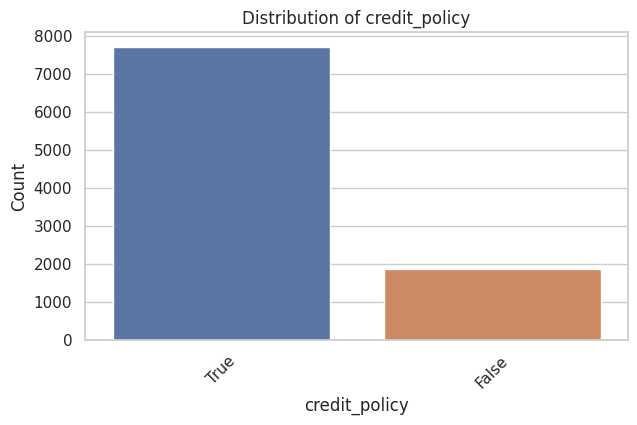

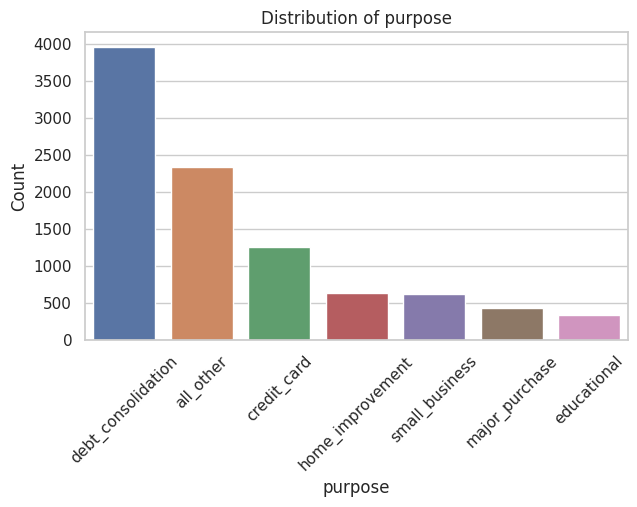

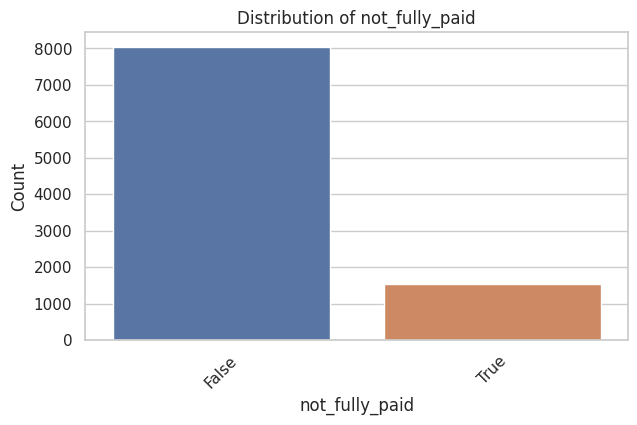

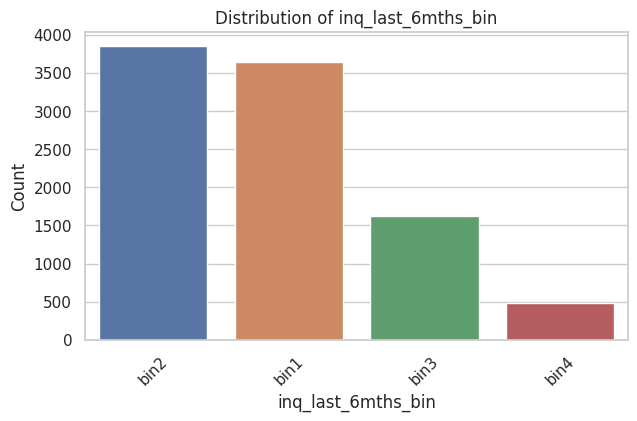

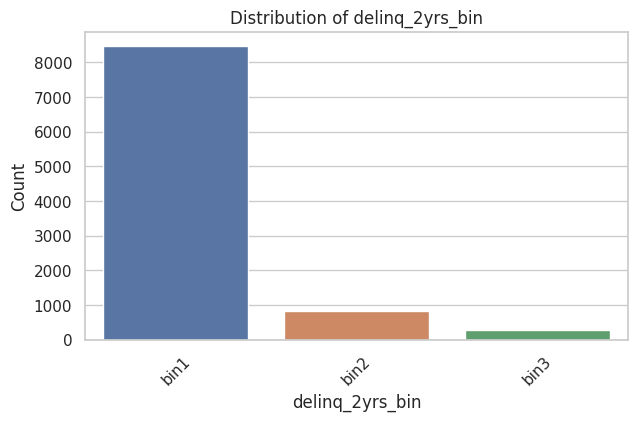

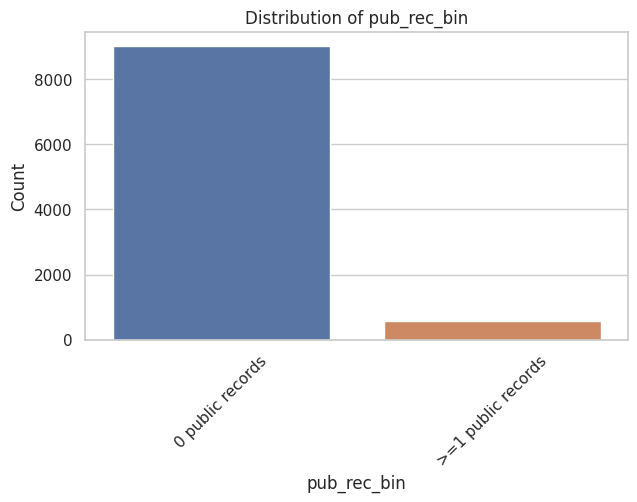

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select categorical and boolean features
cat_cols = df.select_dtypes(include=['object', 'bool']).columns
print("Categorical / Boolean features:", cat_cols)

# Set seaborn style
sns.set(style="whitegrid")

# Loop through each categorical/boolean column
for col in cat_cols:
    plt.figure(figsize=(7,4))
    
    # Barplot for count of each category
    sns.countplot(x=col, data=df, order=df[col].value_counts().index)
    
    # Add title and labels
    plt.title(f"Distribution of {col}")
    plt.ylabel("Count")
    plt.xlabel(col)
    
    plt.xticks(rotation=45)  # Rotate x labels for readability
    plt.show()


In [9]:
# Remove % if present and convert to float
df['revol_util'] = df['revol_util'].replace('%', '', regex=True).astype(float)

# Select all records where revol_util > 100
over_100_records = df[df['revol_util'] > 100]

# Show number of such records
print(f"Number of records with revol_util > 100: {len(over_100_records)}\n")

# Display all columns for these records
print(over_100_records)


Number of records with revol_util > 100: 27

      credit_policy             purpose  int_rate  installment  \
7777          False         credit_card    0.1438        42.96   
7895          False  debt_consolidation    0.1438       149.48   
7914          False  debt_consolidation    0.1186        23.21   
7922          False         credit_card    0.1438       359.95   
7923          False           all_other    0.0933       287.59   
7957          False  debt_consolidation    0.1786        88.41   
7982          False         credit_card    0.1438       137.45   
7991          False           all_other    0.0996        51.60   
8056          False           all_other    0.1059        78.11   
8073          False         educational    0.1375       495.52   
8091          False  debt_consolidation    0.1691       154.90   
8129          False  debt_consolidation    0.1583       701.47   
8176          False  debt_consolidation    0.1425       171.50   
8187          False         cre

In [10]:
# Clean column names (if not done yet)
df.columns = df.columns.str.strip().str.replace('.', '_')

# Convert revol_util to numeric (remove % if present)
df['revol_util'] = df['revol_util'].replace('%', '', regex=True).astype(float)

over_100 = df[df['revol_util'] > 100]
print(f"Number of records with revol_util > 100 before capping: {len(over_100)}\n")

# Show all columns for inspection
print(over_100)

df.loc[df['revol_util'] > 100, 'revol_util'] = 100

# Check if any values are still > 100
over_100_after = df[df['revol_util'] > 100]
print(f"\nNumber of records with revol_util > 100 after capping: {len(over_100_after)}")  # should be 0

# Show all columns for rows that were capped
capped_records = df[df['revol_util'] == 100]
print(capped_records)


Number of records with revol_util > 100 before capping: 27

      credit_policy             purpose  int_rate  installment  \
7777          False         credit_card    0.1438        42.96   
7895          False  debt_consolidation    0.1438       149.48   
7914          False  debt_consolidation    0.1186        23.21   
7922          False         credit_card    0.1438       359.95   
7923          False           all_other    0.0933       287.59   
7957          False  debt_consolidation    0.1786        88.41   
7982          False         credit_card    0.1438       137.45   
7991          False           all_other    0.0996        51.60   
8056          False           all_other    0.1059        78.11   
8073          False         educational    0.1375       495.52   
8091          False  debt_consolidation    0.1691       154.90   
8129          False  debt_consolidation    0.1583       701.47   
8176          False  debt_consolidation    0.1425       171.50   
8187          Fa

Numerical features: ['int_rate', 'installment', 'log_annual_inc', 'dti', 'fico', 'days_with_cr_line', 'revol_bal', 'revol_util', 'inq_last_6mths', 'delinq_2yrs', 'pub_rec']


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

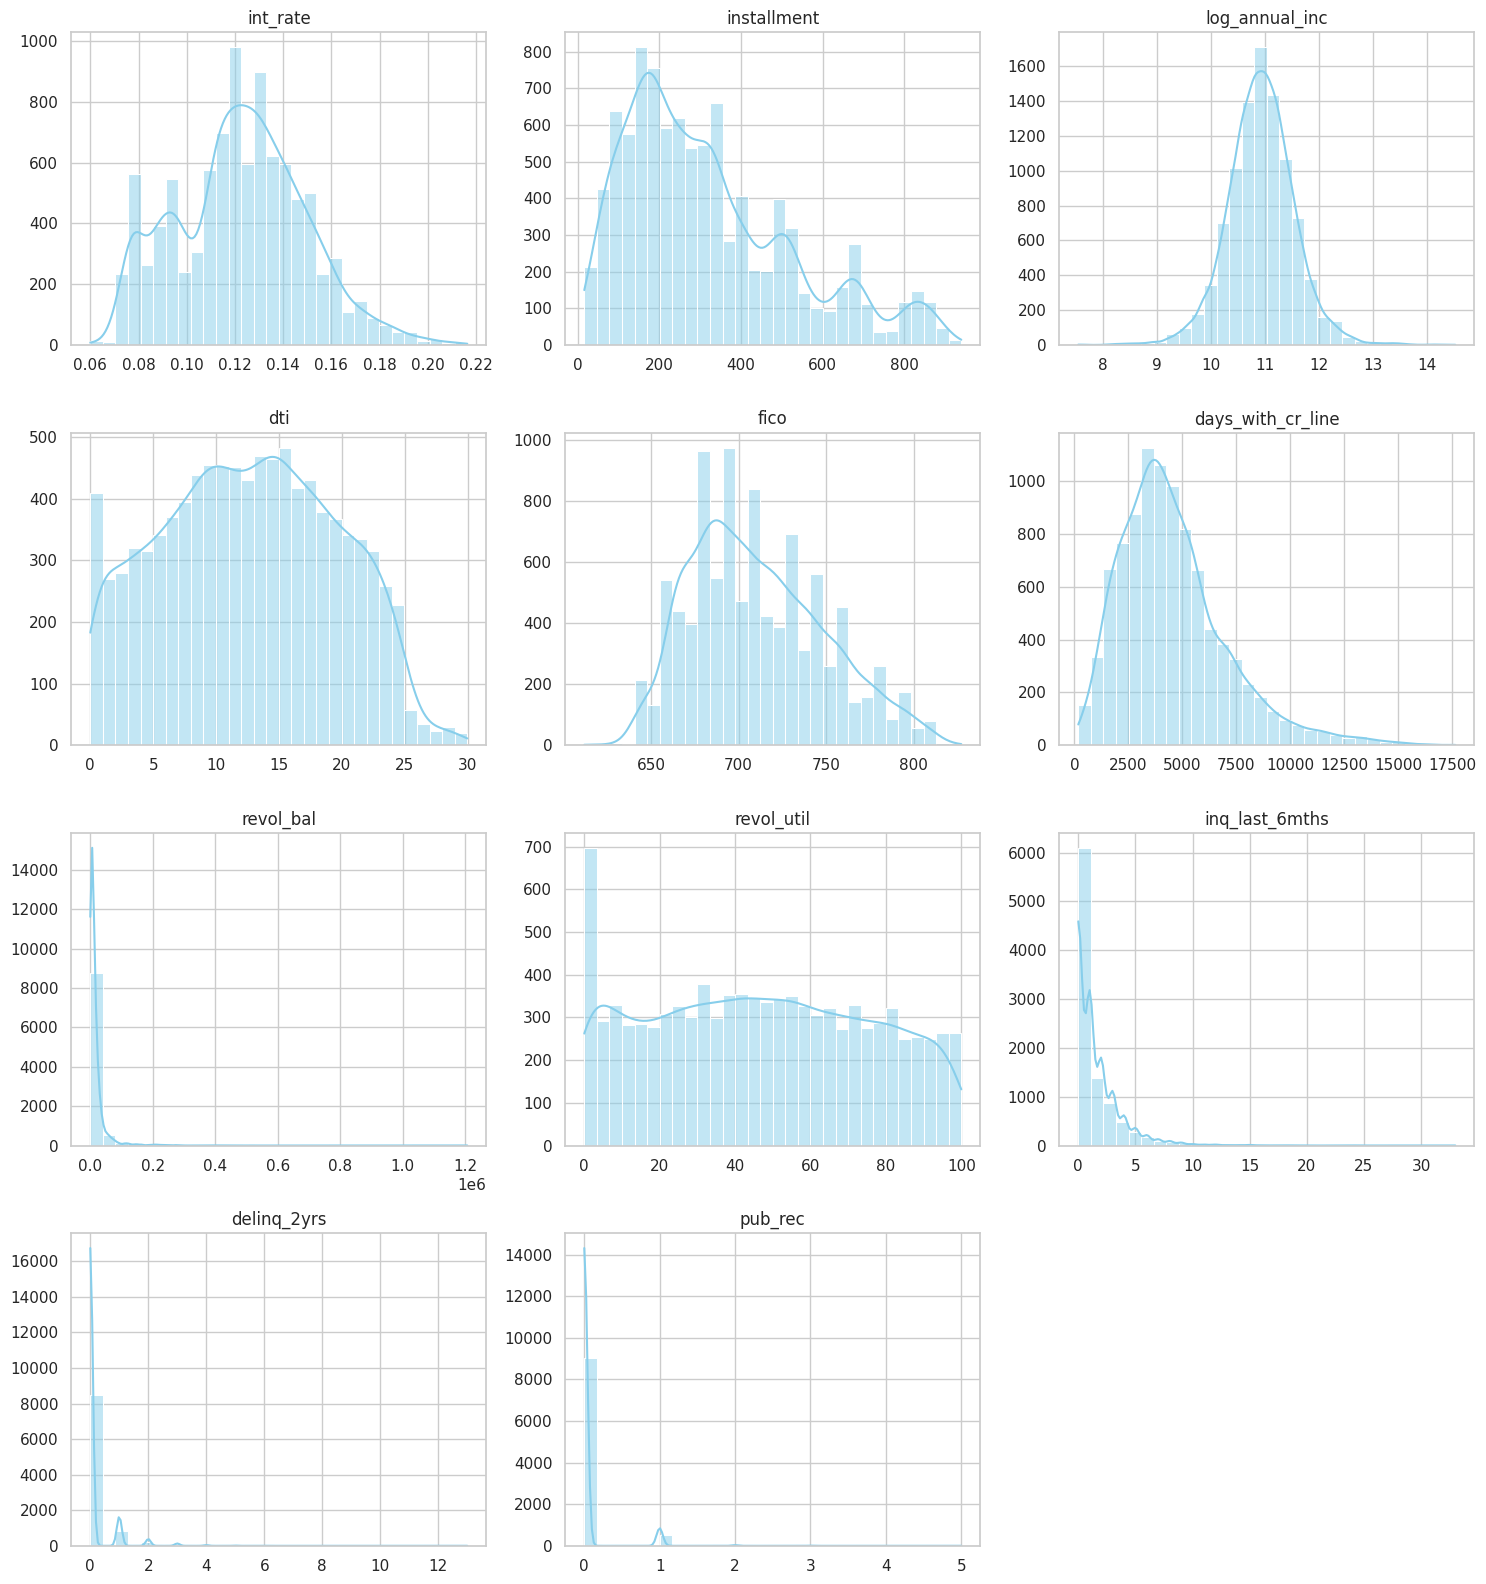

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# -------------------------------
# 1️⃣ Identify numerical columns
# -------------------------------
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
print("Numerical features:", num_cols.tolist())

# -------------------------------
# 2️⃣ Clean numerical data
# -------------------------------
# Replace +inf/-inf with NaN
df[num_cols] = df[num_cols].replace([np.inf, -np.inf], np.nan)

# Optional: fill NaN with median for plotting
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# -------------------------------
# 3️⃣ Plot histograms in a grid
# -------------------------------
sns.set(style="whitegrid")

n_cols = 3  # number of plots per row
n_rows = int(np.ceil(len(num_cols) / n_cols))

plt.figure(figsize=(n_cols*5, n_rows*4))

for i, col in enumerate(num_cols):
    plt.subplot(n_rows, n_cols, i+1)
    sns.histplot(df[col], bins=30, kde=True, color='skyblue')
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()


count    9.578000e+03
mean     1.691396e+04
std      3.375619e+04
min      0.000000e+00
25%      3.187000e+03
50%      8.596000e+03
75%      1.824950e+04
max      1.207359e+06
Name: revol_bal, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


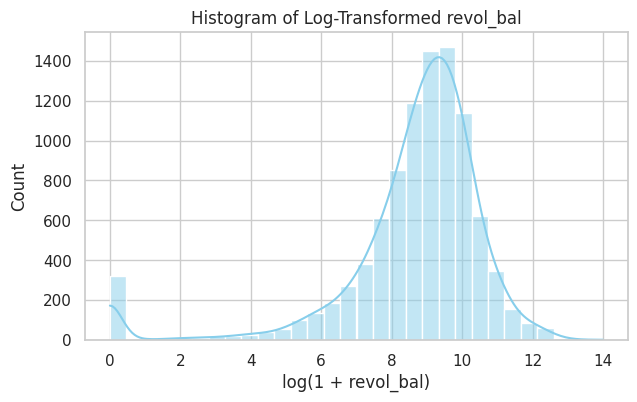

In [12]:
# -----------------------------------------------------------
# 1️⃣ Import libraries
# -----------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------------------------------
# 3️⃣ Check for missing or invalid values
# -----------------------------------------------------------
print(df['revol_bal'].describe())

# -----------------------------------------------------------
# 4️⃣ Apply logarithmic transformation
#     Using log1p(x) = log(1 + x) to safely handle zeros
# -----------------------------------------------------------
df['revol_bal_log'] = np.log1p(df['revol_bal'])

# -----------------------------------------------------------
# 5️⃣ Plot histogram of the log-transformed feature
# -----------------------------------------------------------
sns.set(style="whitegrid")

plt.figure(figsize=(7,4))
sns.histplot(df['revol_bal_log'], bins=30, kde=True, color='skyblue')
plt.title('Histogram of Log-Transformed revol_bal')
plt.xlabel('log(1 + revol_bal)')
plt.ylabel('Count')
plt.show()


🔢 Numerical features: ['int_rate', 'installment', 'log_annual_inc', 'dti', 'fico', 'days_with_cr_line', 'revol_bal', 'revol_util', 'inq_last_6mths', 'delinq_2yrs', 'pub_rec', 'revol_bal_log']

📊 Spearman Correlation Matrix:
                   int_rate  installment  log_annual_inc       dti      fico  \
int_rate           1.000000     0.242914        0.041648  0.216114 -0.744986   
installment        0.242914     1.000000        0.431405  0.062547  0.085257   
log_annual_inc     0.041648     0.431405        1.000000 -0.059672  0.107878   
dti                0.216114     0.062547       -0.059672  1.000000 -0.214496   
fico              -0.744986     0.085257        0.107878 -0.214496  1.000000   
days_with_cr_line -0.133584     0.201920        0.400251  0.072858  0.251729   
revol_bal          0.148719     0.351844        0.415817  0.375950 -0.094562   
revol_util         0.472965     0.096014        0.053173  0.333658 -0.520085   
inq_last_6mths     0.174137    -0.006740        0.030574

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


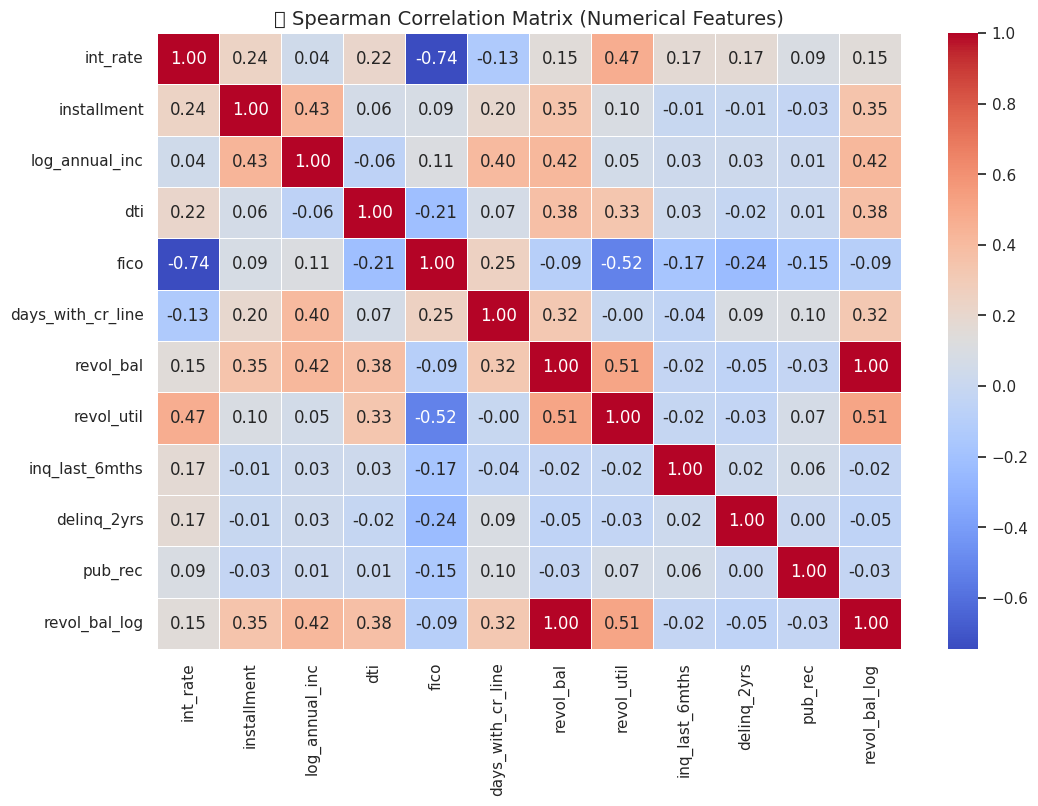

In [13]:
# ------------------------------------------------------------
# 1️⃣ Import libraries
# ------------------------------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 2️⃣ Select only numerical features
# ------------------------------------------------------------
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
print("🔢 Numerical features:", num_cols.tolist())

# ------------------------------------------------------------
# 3️⃣ Compute Spearman correlation matrix
# ------------------------------------------------------------
corr_spearman = df[num_cols].corr(method='spearman')

# ------------------------------------------------------------
# 4️⃣ Display correlation matrix
# ------------------------------------------------------------
print("\n📊 Spearman Correlation Matrix:")
print(corr_spearman)

# ------------------------------------------------------------
# 5️⃣ Plot heatmap for better visualization
# ------------------------------------------------------------
plt.figure(figsize=(12, 8))
sns.heatmap(corr_spearman, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("🔗 Spearman Correlation Matrix (Numerical Features)", fontsize=14)
plt.show()


In [14]:
# ------------------------------------------------------------
# 1️⃣ One-hot encode 'purpose'
# ------------------------------------------------------------
df_encoded = pd.get_dummies(df, columns=['purpose'], drop_first=False)

# ------------------------------------------------------------
# 2️⃣ Check the new columns
# ------------------------------------------------------------
print("✅ One-hot encoded columns added:")
print([col for col in df_encoded.columns if col.startswith('purpose_')])

# ------------------------------------------------------------
# 3️⃣ Compare dataset shapes
# ------------------------------------------------------------
print(f"\nOriginal shape: {df.shape}")
print(f"New shape after encoding: {df_encoded.shape}")

# ------------------------------------------------------------
# 4️⃣ Optional: view the first few rows
# ------------------------------------------------------------
df_encoded.head()


✅ One-hot encoded columns added:
['purpose_all_other', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_major_purchase', 'purpose_small_business']

Original shape: (9578, 18)
New shape after encoding: (9578, 24)


,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,...,delinq_2yrs_bin,pub_rec_bin,revol_bal_log,purpose_all_other,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,True,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,...,bin1,0 public records,10.270039,False,False,True,False,False,False,False
1,True,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,...,bin1,0 public records,10.422995,False,True,False,False,False,False,False
2,True,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,...,bin1,0 public records,8.163941,False,False,True,False,False,False,False
3,True,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,...,bin1,0 public records,10.424303,False,False,True,False,False,False,False
4,True,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,...,bin2,0 public records,8.464003,False,True,False,False,False,False,False


In [15]:
# ------------------------------------------------------------
# Drop multiple columns safely
# ------------------------------------------------------------
cols_to_drop = ['revol_bal', 'inq_last_6mths', 'delinq_2yrs', 'pub_rec']

# Only drop columns that exist in df
existing_cols = [col for col in cols_to_drop if col in df.columns]

if existing_cols:
    df = df.drop(columns=existing_cols)
    print(f"✅ Dropped columns: {existing_cols}")
else:
    print("⚠️ None of the specified columns were found in the dataset.")

# ------------------------------------------------------------
# Check remaining columns
# ------------------------------------------------------------
print("\n📋 Remaining columns in dataset:")
print(df.columns.tolist())


✅ Dropped columns: ['revol_bal', 'inq_last_6mths', 'delinq_2yrs', 'pub_rec']

📋 Remaining columns in dataset:
['credit_policy', 'purpose', 'int_rate', 'installment', 'log_annual_inc', 'dti', 'fico', 'days_with_cr_line', 'revol_util', 'not_fully_paid', 'inq_last_6mths_bin', 'delinq_2yrs_bin', 'pub_rec_bin', 'revol_bal_log']


In [16]:
# ------------------------------------------------------------
# 1️⃣ Import LabelEncoder
# ------------------------------------------------------------
from sklearn.preprocessing import LabelEncoder

# ------------------------------------------------------------
# 2️⃣ Identify categorical (object-type) columns
# ------------------------------------------------------------
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print("📂 Categorical columns to encode:", cat_cols)

# ------------------------------------------------------------
# 3️⃣ Apply Label Encoding to each categorical column
# ------------------------------------------------------------
le = LabelEncoder()

for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

print("\n✅ Label encoding applied successfully.")

# ------------------------------------------------------------
# 4️⃣ Check result
# ------------------------------------------------------------
print("\n📋 Updated dataset info:")
print(df.info())

print("\n🔢 Example of encoded columns:")
print(df[cat_cols].head())


📂 Categorical columns to encode: ['purpose', 'inq_last_6mths_bin', 'delinq_2yrs_bin', 'pub_rec_bin']

✅ Label encoding applied successfully.

📋 Updated dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   credit_policy       9578 non-null   bool   
 1   purpose             9578 non-null   int64  
 2   int_rate            9578 non-null   float64
 3   installment         9578 non-null   float64
 4   log_annual_inc      9578 non-null   float64
 5   dti                 9578 non-null   float64
 6   fico                9578 non-null   int64  
 7   days_with_cr_line   9578 non-null   float64
 8   revol_util          9578 non-null   float64
 9   not_fully_paid      9578 non-null   bool   
 10  inq_last_6mths_bin  9578 non-null   int64  
 11  delinq_2yrs_bin     9578 non-null   int64  
 12  pub_rec_bin         9578 non-null   

In [17]:
# ------------------------------------------------------------
# 1️⃣ Import libraries
# ------------------------------------------------------------
from sklearn.model_selection import train_test_split

# ------------------------------------------------------------
# 2️⃣ Separate features (X) and target (y)
# ------------------------------------------------------------
X = df.drop(columns=['not_fully_paid'])  # Features
y = df['not_fully_paid']                 # Target

print("✅ Features and target separated successfully.")
print(f"🔹 Shape of X (features): {X.shape}")
print(f"🔹 Shape of y (target): {y.shape}")

# ------------------------------------------------------------
# 3️⃣ Split into Train and Test sets
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,       # 20% test data
    random_state=42,     # reproducibility
    stratify=y           # keep same class distribution
)

# ------------------------------------------------------------
# 4️⃣ Check results
# ------------------------------------------------------------
print("\n📊 Data split complete!")
print(f"🔹 Training set size: {X_train.shape[0]} rows")
print(f"🔹 Test set size: {X_test.shape[0]} rows")

# Verify stratification worked
print("\n🔎 Target distribution comparison:")
print("Train set:")
print(y_train.value_counts(normalize=True))
print("\nTest set:")
print(y_test.value_counts(normalize=True))


✅ Features and target separated successfully.
🔹 Shape of X (features): (9578, 13)
🔹 Shape of y (target): (9578,)

📊 Data split complete!
🔹 Training set size: 7662 rows
🔹 Test set size: 1916 rows

🔎 Target distribution comparison:
Train set:
not_fully_paid
False    0.83999
True     0.16001
Name: proportion, dtype: float64

Test set:
not_fully_paid
False    0.83977
True     0.16023
Name: proportion, dtype: float64


In [18]:
# ------------------------------------------------------------
# 1️⃣ Import StandardScaler (Normalization)
# ------------------------------------------------------------
from sklearn.preprocessing import StandardScaler

# ------------------------------------------------------------
# 2️⃣ Identify numerical features
# ------------------------------------------------------------
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("🔢 Numerical columns to normalize:", num_cols)

# ------------------------------------------------------------
# 3️⃣ Initialize scaler
# ------------------------------------------------------------
scaler = StandardScaler()

# ------------------------------------------------------------
# 4️⃣ Fit scaler on TRAINING data and transform it
# ------------------------------------------------------------
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])

# ------------------------------------------------------------
# 5️⃣ Apply (transform) the same scaler on TEST data
# ------------------------------------------------------------
X_test[num_cols] = scaler.transform(X_test[num_cols])

# ------------------------------------------------------------
# 6️⃣ Verify normalization worked
# ------------------------------------------------------------
# print("\n✅ Normalization applied successfully!")

# print("\n📊 Summary statistics after normalization (training set):")
# print(X_train[num_cols].describe().T[['mean', 'std']])
X_train.head()


🔢 Numerical columns to normalize: ['purpose', 'int_rate', 'installment', 'log_annual_inc', 'dti', 'fico', 'days_with_cr_line', 'revol_util', 'inq_last_6mths_bin', 'delinq_2yrs_bin', 'pub_rec_bin', 'revol_bal_log']


,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_util,inq_last_6mths_bin,delinq_2yrs_bin,pub_rec_bin,revol_bal_log
6381,True,-0.555629,0.744534,1.109194,0.696658,0.012171,-0.629324,0.275685,0.952688,0.130142,2.009714,-0.252142,0.510377
7589,True,-0.555629,-1.779946,-0.795226,0.174696,0.017975,0.689102,0.234302,-0.150510,-1.034752,-0.340474,-0.252142,0.346771
465,True,0.033770,-0.912273,-0.889878,-0.252212,-0.101001,0.161732,0.699294,-0.339532,-1.034752,2.009714,-0.252142,0.583595
5343,True,-1.145027,0.486476,0.096296,1.097154,0.506940,-0.629324,-0.493588,0.086626,0.130142,-0.340474,-0.252142,-0.571997
8016,False,0.033770,0.318178,0.576044,1.172312,-0.333151,-1.288536,-1.555593,-1.614567,1.295036,-0.340474,-0.252142,-3.950224


In [19]:
X_test.head()

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_util,inq_last_6mths_bin,delinq_2yrs_bin,pub_rec_bin,revol_bal_log
8157,False,0.033770,1.212031,0.480230,0.164232,0.399571,-1.684064,-1.078288,0.794597,-1.034752,-0.340474,-0.252142,0.325094
1928,True,0.033770,-1.596687,-1.263839,-0.185788,0.933514,0.557259,0.080371,-0.040534,-1.034752,-0.340474,-0.252142,0.741887
2779,True,-1.145027,0.568756,1.751231,1.477852,-0.798900,0.029889,0.210437,-0.745069,-1.034752,-0.340474,-0.252142,0.148504
2520,True,-1.145027,0.213459,-1.234983,-2.144838,-0.311387,-0.233796,-0.894542,-1.487408,0.130142,-0.340474,-0.252142,-0.977857
2601,True,1.212568,1.275610,0.146309,0.027415,-0.726354,-0.761166,-0.684511,-0.439198,0.130142,-0.340474,-0.252142,-0.509620



📊 Logistic Regression Evaluation Results
              precision    recall  f1-score   support

       False       0.84      1.00      0.91      1609
        True       0.60      0.01      0.02       307

    accuracy                           0.84      1916
   macro avg       0.72      0.50      0.47      1916
weighted avg       0.80      0.84      0.77      1916



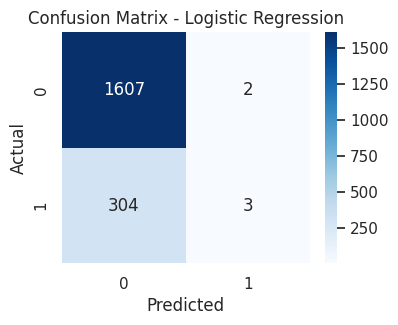


📊 Random Forest Evaluation Results
              precision    recall  f1-score   support

       False       0.84      0.99      0.91      1609
        True       0.38      0.02      0.04       307

    accuracy                           0.84      1916
   macro avg       0.61      0.51      0.47      1916
weighted avg       0.77      0.84      0.77      1916



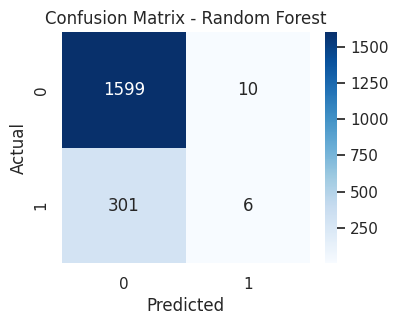


📊 XGBoost Evaluation Results
              precision    recall  f1-score   support

       False       0.85      0.97      0.90      1609
        True       0.30      0.07      0.12       307

    accuracy                           0.82      1916
   macro avg       0.57      0.52      0.51      1916
weighted avg       0.76      0.82      0.78      1916



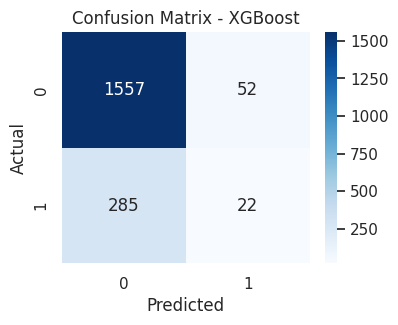


🏁 Model Comparison Results:
                 Model  Accuracy  Precision    Recall  F1 Score   ROC-AUC
0  Logistic Regression  0.840292   0.600000  0.009772  0.019231  0.677460
1        Random Forest  0.837683   0.375000  0.019544  0.037152  0.663464
2              XGBoost  0.824113   0.297297  0.071661  0.115486  0.627786


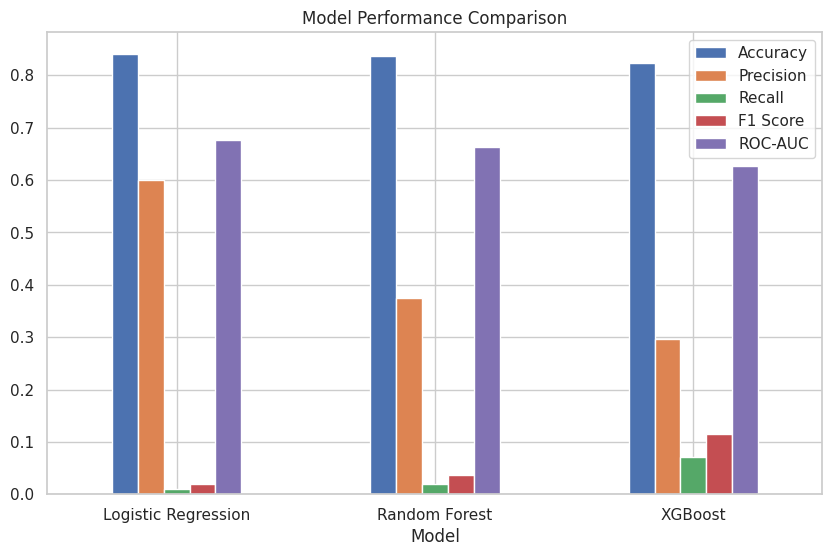

In [20]:
# ------------------------------------------------------------
# 1️⃣ Import Libraries
# ------------------------------------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------
# 2️⃣ Define Models
# ------------------------------------------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# ------------------------------------------------------------
# 3️⃣ Train and Evaluate
# ------------------------------------------------------------
results = []

for name, model in models.items():
    # Train model
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "ROC-AUC": roc
    })
    
    # Print classification report
    print(f"\n{'='*60}")
    print(f"📊 {name} Evaluation Results")
    print('='*60)
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    plt.figure(figsize=(4,3))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# ------------------------------------------------------------
# 4️⃣ Compare All Models
# ------------------------------------------------------------
results_df = pd.DataFrame(results)
print("\n🏁 Model Comparison Results:")
print(results_df.sort_values(by='ROC-AUC', ascending=False))

# Plot performance comparison
results_df.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']].plot(
    kind='bar', figsize=(10,6), rot=0, title="Model Performance Comparison"
)
plt.show()


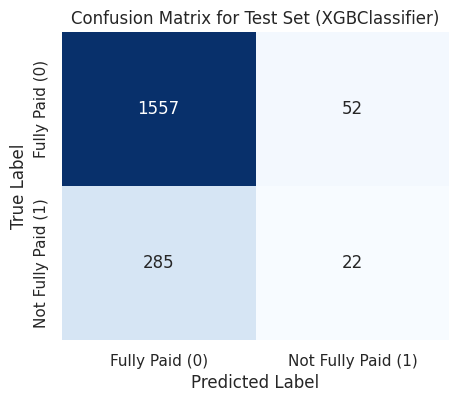


📊 Confusion Matrix Values:
True Negatives:  1557
False Positives: 52
False Negatives: 285
True Positives:  22


In [21]:
# ------------------------------------------------------------
# 1️⃣ Import Libraries
# ------------------------------------------------------------
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------
# 2️⃣ Choose the model you want to evaluate
# ------------------------------------------------------------
# Example: you can change this to 'rf_model' or 'xgb_model' as needed
model = models["XGBoost"]   # or "Random Forest" or "Logistic Regression"

# ------------------------------------------------------------
# 3️⃣ Make predictions on the test set
# ------------------------------------------------------------
y_pred = model.predict(X_test)

# ------------------------------------------------------------
# 4️⃣ Compute confusion matrix
# ------------------------------------------------------------
cm = confusion_matrix(y_test, y_pred)

# ------------------------------------------------------------
# 5️⃣ Plot confusion matrix
# ------------------------------------------------------------
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title(f'Confusion Matrix for Test Set ({model.__class__.__name__})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Custom axis labels
plt.xticks([0.5, 1.5], ['Fully Paid (0)', 'Not Fully Paid (1)'])
plt.yticks([0.5, 1.5], ['Fully Paid (0)', 'Not Fully Paid (1)'])

plt.show()

# ------------------------------------------------------------
# 6️⃣ Optional: Show exact values
# ------------------------------------------------------------
tn, fp, fn, tp = cm.ravel()
print("\n📊 Confusion Matrix Values:")
print(f"True Negatives:  {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives:  {tp}")


Balanced class counts:
not_fully_paid
True     6436
False    6436
Name: count, dtype: int64

Logistic Regression Classification Report
              precision    recall  f1-score   support

       False       0.89      0.66      0.76      1609
        True       0.25      0.59      0.35       307

    accuracy                           0.65      1916
   macro avg       0.57      0.63      0.55      1916
weighted avg       0.79      0.65      0.69      1916



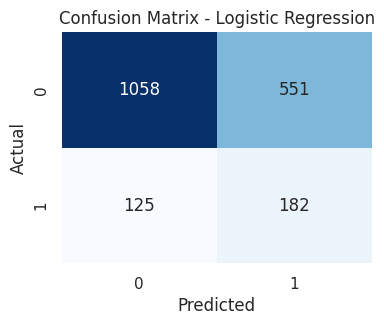


Random Forest Classification Report
              precision    recall  f1-score   support

       False       0.85      0.98      0.91      1609
        True       0.38      0.07      0.12       307

    accuracy                           0.83      1916
   macro avg       0.61      0.52      0.51      1916
weighted avg       0.77      0.83      0.78      1916



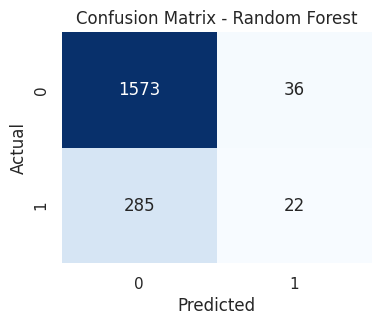


XGBoost Classification Report
              precision    recall  f1-score   support

       False       0.85      0.87      0.86      1609
        True       0.25      0.22      0.24       307

    accuracy                           0.77      1916
   macro avg       0.55      0.55      0.55      1916
weighted avg       0.76      0.77      0.76      1916



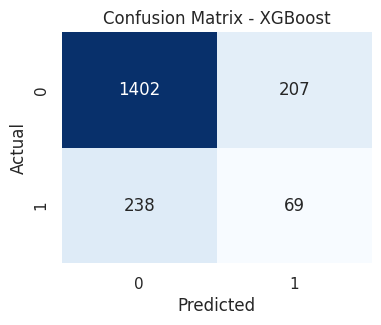


🏁 Model Comparison (Balanced Training Set)
                 Model  Accuracy   ROC-AUC
0  Logistic Regression  0.647182  0.675885
1        Random Forest  0.832463  0.664725
2              XGBoost  0.767745  0.594111


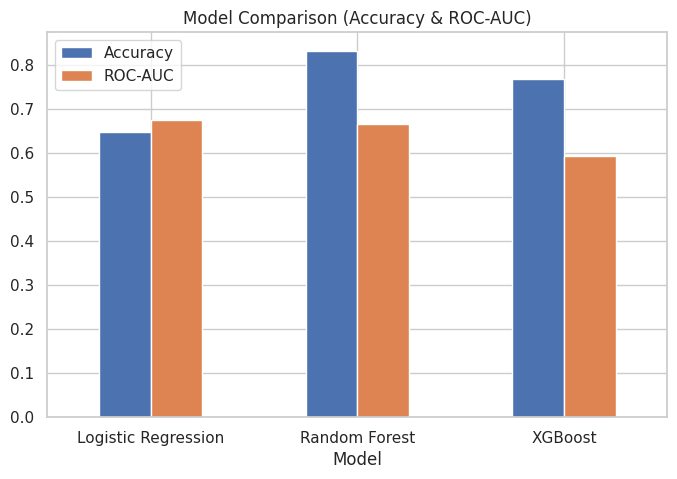

In [22]:
# -------------------------
# 1️⃣ Manual oversampling of minority class
# -------------------------
from sklearn.utils import resample
import pandas as pd

# Separate majority and minority classes
X_train_majority = X_train[y_train == 0]
y_train_majority = y_train[y_train == 0]

X_train_minority = X_train[y_train == 1]
y_train_minority = y_train[y_train == 1]

# Oversample minority to match majority
X_min_oversampled, y_min_oversampled = resample(
    X_train_minority, y_train_minority,
    replace=True,
    n_samples=len(X_train_majority),
    random_state=42
)

# Combine
X_train_balanced = pd.concat([X_train_majority, X_min_oversampled]).reset_index(drop=True)
y_train_balanced = pd.concat([y_train_majority, y_min_oversampled]).reset_index(drop=True)

# Shuffle
X_train_balanced = X_train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
y_train_balanced = y_train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced class counts:")
print(y_train_balanced.value_counts())

# -------------------------
# 2️⃣ Train all three models
# -------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# -------------------------
# 3️⃣ Train and evaluate
# -------------------------
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

results = []

for name, model in models.items():
    # Train
    model.fit(X_train_balanced, y_train_balanced)
    
    # Predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    acc = (y_pred == y_test).mean()
    roc = roc_auc_score(y_test, y_proba)
    
    results.append({"Model": name, "Accuracy": acc, "ROC-AUC": roc})
    
    # Classification report
    print(f"\n{'='*50}\n{name} Classification Report\n{'='*50}")
    print(classification_report(y_test, y_pred))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# -------------------------
# 4️⃣ Compare all models
# -------------------------
results_df = pd.DataFrame(results)
print("\n🏁 Model Comparison (Balanced Training Set)")
print(results_df.sort_values(by='ROC-AUC', ascending=False))

# Optional bar plot
results_df.set_index('Model')[['Accuracy', 'ROC-AUC']].plot(
    kind='bar', figsize=(8,5), rot=0, title='Model Comparison (Accuracy & ROC-AUC)'
)
plt.show()
